In [1]:
import pandas as pd
!pip install shapely

DEPRECATION: pandas 0.23.4 has a non-standard dependency specifier pytz>=2011k. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pandas or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: unyt 2.8.0 has a non-standard dependency specifier numpy>="1.13.0". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of unyt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
%run ROUTINES/gauss_asym.py

In [3]:
%matplotlib widget

## Load fit info

In [4]:
#df_fits = pd.read_csv('fit_info/fit_sobrevivientes_rho_arm2.csv')

id_halo='324123'
df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv')
df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis = 1)
df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis = 1)

In [5]:
df_fits.tail(3)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
12,0.000153,20.649260,0.05,False,-0.002541,12.0,0.993859,0.000008,16633.512643,20976.507756,82.254412,"[19.22356654879216, 19.34664204636211, 19.3983...",8.775974,"[2.278892018730768e-05, 3.4512346821853284e-05...",18.752435
13,0.000141,21.512855,0.05,False,5.276636,13.0,2.060098,0.000028,0.100466,3.033225,0.611203,"[20.878760220670483, 21.058393884748487, 21.12...",11.892857,"[8.704655476282266e-06, 7.776088549893095e-06,...",19.219968
14,0.000078,23.584760,0.05,False,-3.979080,14.0,0.856246,0.000005,0.042884,1.979880,0.097951,"[21.809333141624176, 21.881317535346977, 22.13...",17.503247,"[1.3325664944827368e-05, 1.367554948853958e-05...",14.934253


In [6]:
params = df_fits.iloc[0] # Para investigar los resultado del fit de un punto, llamamos su fila en el DataFrame

In [7]:
params

amplitude                                                 4.70038e-05
center                                                        9.27942
delta                                                            0.05
fractured                                                       False
gamma                                                         6.17999
id_tracing                                                          0
sigma                                                         1.31517
stderr_amplitude                                           3.7484e-06
stderr_center                                                 0.04554
stderr_gamma                                                  3.02776
stderr_sigma                                                 0.166032
x                   [9.195870943384389, 9.245276387828238, 9.28715...
x_tracing                                                   -0.574675
y                   [1.1601577666314614e-05, 1.5646316630690358e-0...
y_tracing           

In [8]:
#import numpy as np

# Convertir las columnas 'x' y 'y' de cadenas a arrays numéricos
#params['x'] = np.array(params['x'].split('\\n'), dtype=float)
#params['y'] = np.array(params['y'].split('\\n'), dtype=float)

# Verificar los resultados
#print("X values:", params['x'])
#print("Y values:", params['y'])


In [9]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


In [10]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.001):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



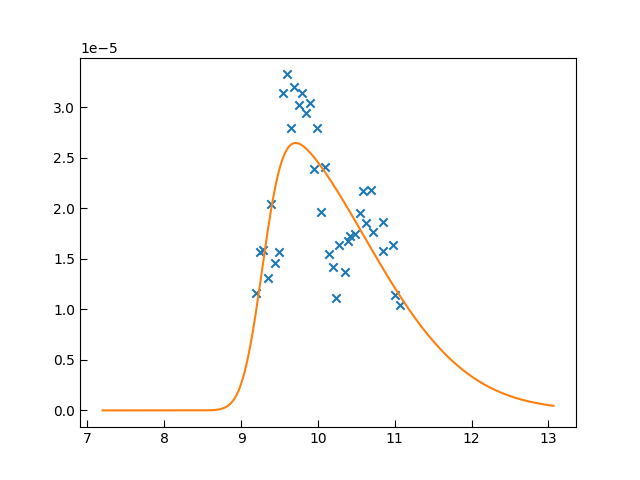

In [11]:
%matplotlib widget
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficamos el fit y los puntos con los que se hizo el fit
fig, ax = plt.subplots()
ax.scatter(params.x, params.y, color = 'C0', marker = 'x') # Envoltorio
model_eval = eval_fitted_model_with_given_params(params, dx = 0.01) # Funcion en gauss_asym.py
x_eval = model_eval['x_eval']
y_eval = model_eval['y_eval']
ax.plot(x_eval, y_eval,color = 'C1'); # Fit

## Calculate width of a fit

In [12]:
%run ROUTINES/gauss_asym.py

In [13]:
dx = 0.001 # Discretizacion para mapear la gaussiana

In [14]:
width_info = find_widths_of_skewed_gaussian_dani(params, dx = dx) # Funcion en gauss_asym.py

In [15]:
width_info # Retorna la ubicacion del maximo (x_max, y_max) y el ancho a la izquierda (w1) y a la derecha (w2)

{'x_max': 9.709870943385228,
 'y_max': 2.6446445500264433e-05,
 'w1': 0.44981126291991025,
 'w2': 1.2000366494555443}

In [16]:
#fig, ax = plt.subplots(figsize=(10,5))
#plot_fit_and_widths(params, ax, dx = dx) # Funcion en gauss_asym.py

In [17]:
# Podemos aplicar find_widths_of_skewed_gaussian() a toda la tabla con la informacion de los parametros 

df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [18]:


df_fits.head(4)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing,width_info,x_max,y_max,w1,w2
0,0.000047,9.279418,0.05,False,6.179990,0.0,1.315170,0.000004,0.045540,3.027758,0.166032,"[9.195870943384389, 9.245276387828238, 9.28715...",-0.574675,"[1.1601577666314614e-05, 1.5646316630690358e-0...",-10.312500,"{'x_max': 9.709870943385228, 'y_max': 2.644644...",9.709871,0.000026,0.449811,1.200037
1,0.000069,9.505440,0.05,False,1.259071,1.0,1.204320,0.000009,0.707770,2.387243,0.792543,"[8.819071961135856, 9.010166578563613, 9.01820...",-2.834416,"[7.472269256266808e-06, 9.183958385622233e-06,...",-10.078734,"{'x_max': 10.149071961136968, 'y_max': 2.96581...",10.149072,0.000030,1.032314,1.136521
2,0.000083,10.073588,0.05,False,-0.062420,2.0,1.063962,0.000016,1160.424124,1373.489001,57.799666,"[9.269330964066059, 9.315312826914028, 9.36131...",-4.938312,"[1.219135311552658e-05, 2.706794294705104e-05,...",-8.831981,"{'x_max': 10.020330964066979, 'y_max': 3.11986...",10.020331,0.000031,1.250785,1.251556
3,0.000046,9.233571,0.05,False,6.623711,3.0,1.168867,0.000004,0.042171,3.033831,0.169003,"[9.011420319888817, 9.129148577858174, 9.16930...",-7.353896,"[9.124540643391795e-06, 1.0616978700370333e-05...",-7.273539,"{'x_max': 9.599420319889681, 'y_max': 2.943632...",9.599420,0.000029,0.380440,1.076546


## Results

In [19]:
df_tracing_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_tracing_arm1['arm'] = [1]*len(df_tracing_arm1)
df_tracing_arm1['id'] = np.arange(0,len(df_tracing_arm1),1)

df_tracing_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_tracing_arm2['arm'] = [2]*len(df_tracing_arm2)
df_tracing_arm2['id'] = np.arange(0,len(df_tracing_arm2),1)

df_arms = pd.concat([df_tracing_arm1,df_tracing_arm2], axis = 0).reset_index(drop=True)

In [20]:
df_arms.head(3)

,x,y,arm,id
0,-0.574675,-10.312500,1,0
1,-2.834416,-10.078734,1,1
2,-4.938312,-8.831981,1,2


In [21]:
# Aplicar la función en las columnas 'x' y 'y'
dfs = []
for i, arm in enumerate(['arm1', 'arm2']):
    df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_{arm}_all_points_HALO{id_halo}_.csv')
    
    # Aplicar la limpieza y conversión en las columnas 'x' y 'y'
    df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis=1)
    df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis=1)
    print(i,arm)
    
    # Añadir la columna 'arm'
    df_fits['arm'] = [i+1] * len(df_fits)
    
    dfs.append(df_fits)



0 arm1
1 arm2


In [22]:
df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [23]:
 df_fits['arm'].nunique()

2

In [24]:
fits_arm1 = df_fits[df_fits.arm == 1]
fits_arm2 = df_fits[df_fits.arm == 2]

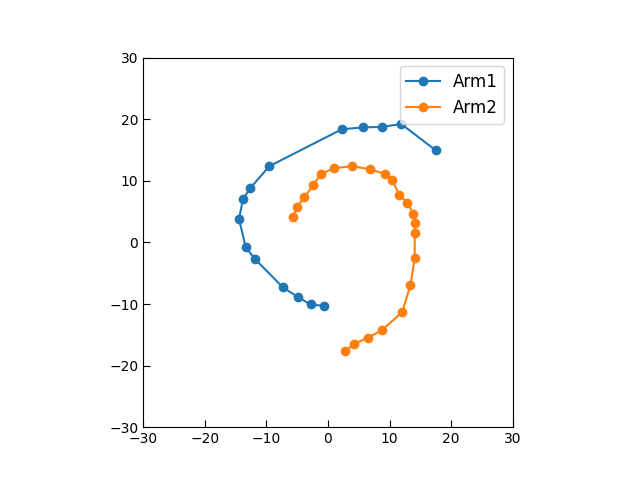

In [25]:
%matplotlib widget
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

fig, ax = plt.subplots()
ax.plot(fits_arm1.x_tracing, fits_arm1.y_tracing, marker = 'o', label = 'Arm1')
ax.plot(fits_arm2.x_tracing, fits_arm2.y_tracing, marker = 'o', label = 'Arm2')
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.legend()
ax.set_aspect('equal')

In [26]:
def calc_euclidean(x1,y1,x2,y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [27]:
dist_previous = []
for i in range(len(df_tracing_arm2)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm2.iloc[i-1].x
        y1 = df_tracing_arm2.iloc[i-1].y
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))

In [28]:
df_tracing_arm2['dist_previous'] = dist_previous
df_tracing_arm2['arm_length'] = df_tracing_arm2.dist_previous.cumsum()



In [29]:
df_tracing_arm2.head(3)

,x,y,arm,id,dist_previous,arm_length
0,-5.717532,4.103084,2,0,7.037434,7.037434
1,-5.016234,5.817370,2,1,1.852187,8.889621
2,-3.847403,7.297890,2,2,1.886294,10.775915


In [30]:
def assign_length(id_tracing, df_tracing):
    length = df_tracing[df_tracing.id == id_tracing].arm_length.values[0]
    return length

In [31]:
fits_arm2['arm_length'] = fits_arm2.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm2), axis = 1)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
fits_arm2.head(3)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,...,y,y_tracing,arm,r_tracing,width_info,x_max,y_max,w1,w2,arm_length
15,0.000043,6.861643,0.005,False,0.739068,0.0,1.077010,0.000002,0.795773,1.561978,...,"[1.8477057274468608e-05, 5.419827082283566e-06...",4.103084,2,7.037434,"{'x_max': 7.33983027855553, 'y_max': 1.8242754...",7.339830,0.000018,1.096159,1.126917,7.037434
16,0.000051,8.697899,0.005,False,-1.728495,1.0,1.707976,0.000002,0.186885,0.872719,...,"[6.005761431722277e-06, 5.646775932446194e-06,...",5.817370,2,7.681432,"{'x_max': 7.774414607342467, 'y_max': 1.697755...",7.774415,0.000017,1.521974,1.267875,8.889621
17,0.000042,9.780705,0.005,False,-3.844389,2.0,1.696948,0.000003,0.099599,1.707339,...,"[7.033039278236344e-06, 9.939320305428227e-06,...",7.297890,2,8.249951,"{'x_max': 9.05917703465638, 'y_max': 1.7282622...",9.059177,0.000017,1.472669,0.795040,10.775915


In [33]:
fits_arm2.to_csv(f'DATA/results/Halo_{id_halo}_Arm2_widths_Oct10.csv')

In [34]:
fits_arm2[['amplitude', 'center', 'gamma', 'id_tracing',
       'sigma', 'stderr_amplitude', 'stderr_center', 'arm', 'r_tracing', 'w1', 'w2', 'arm_length']]

,amplitude,center,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,arm,r_tracing,w1,w2,arm_length
15,0.000043,6.861643,0.739068,0.0,1.077010,0.000002,0.795773,2,7.037434,1.096159,1.126917,7.037434
16,0.000051,8.697899,-1.728495,1.0,1.707976,0.000002,0.186885,2,7.681432,1.521974,1.267875,8.889621
17,0.000042,9.780705,-3.844389,2.0,1.696948,0.000003,0.099599,2,8.249951,1.472669,0.795040,10.775915
18,0.000076,8.369191,6.434942,3.0,2.478206,0.000004,0.049555,2,9.619593,0.823604,2.273466,13.285199
19,0.000102,10.908528,0.017500,4.0,1.914268,0.000011,19311.720816,2,11.102976,2.253829,2.253489,15.360034
20,0.000072,11.296125,3.366612,5.0,1.580117,0.000006,0.086976,2,12.085133,0.804313,1.360650,17.695098
21,0.000087,14.652715,-10.271616,6.0,2.976349,0.000013,0.175146,2,12.976938,2.898673,0.707075,20.750001
22,0.000043,13.014463,4.023164,7.0,1.108407,0.000005,0.054683,2,13.677005,0.504572,0.965207,23.593890
23,0.000088,15.587239,-9.549826,8.0,2.550701,0.000010,0.157284,2,14.457159,2.461340,0.639737,26.206314
24,0.000093,13.812905,4.207061,9.0,2.427456,0.000012,0.131714,2,14.508242,1.072972,2.122686,27.753023


(-1.0, 1.0)

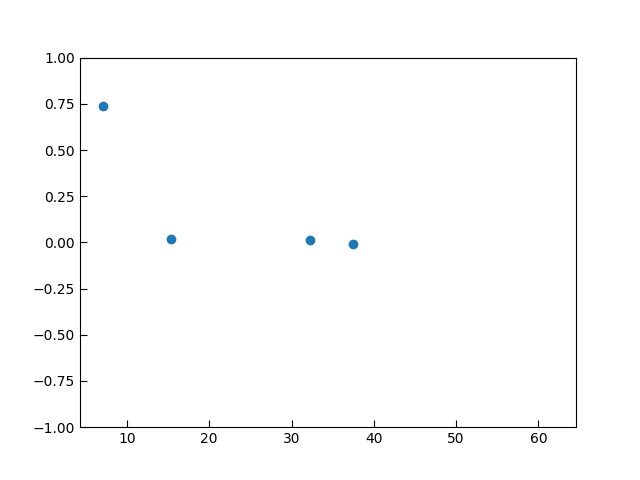

In [35]:
%matplotlib widget
fig,ax = plt.subplots()
ax.scatter(fits_arm2.arm_length, fits_arm2.gamma)
ax.set_ylim(-1,1)

In [36]:
dist_previous = []
for i in range(len(df_tracing_arm1)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm1.iloc[i].x
        y2 = df_tracing_arm1.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm1.iloc[i-1].x
        y1 = df_tracing_arm1.iloc[i-1].y
        
        x2 = df_tracing_arm1.iloc[i].x
        y2 = df_tracing_arm1.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))


df_tracing_arm1['dist_previous'] = dist_previous
df_tracing_arm1['arm_length'] = df_tracing_arm1.dist_previous.cumsum()

In [37]:
fits_arm1['arm_length'] = fits_arm1.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm1), axis = 1)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
fits_arm1.to_csv(f'DATA/results/Halo_{id_halo}_Arm1_widths_Oct10.csv')

In [39]:
fits_arm1[['amplitude', 'center', 'gamma', 'id_tracing',
       'sigma', 'stderr_amplitude', 'stderr_center', 'arm', 'r_tracing', 'w1', 'w2', 'arm_length']]

,amplitude,center,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,arm,r_tracing,w1,w2,arm_length
0,0.000047,9.279418,6.179990,0.0,1.315170,0.000004,0.045540,1,10.328500,0.449811,1.200037,10.328500
1,0.000069,9.505440,1.259071,1.0,1.204320,0.000009,0.707770,1,10.469708,1.032314,1.136521,12.600299
2,0.000083,10.073588,-0.062420,2.0,1.063962,0.000016,1160.424124,1,10.118834,1.250785,1.251556,15.045861
3,0.000046,9.233571,6.623711,3.0,1.168867,0.000004,0.042171,1,10.343315,0.380440,1.076546,17.920542
4,0.000032,12.538581,-8.474159,4.0,0.691587,0.000005,0.051294,1,12.171227,0.656927,0.189569,24.367387
5,0.000044,13.899967,-3.697499,5.0,1.112769,0.000003,0.045185,1,13.378198,0.963268,0.534167,26.752617
6,0.000102,13.919510,3.900705,6.0,2.049036,0.000012,0.121368,1,14.934091,0.951308,1.780011,31.477677
7,0.000134,16.463065,-6.464163,7.0,2.556182,0.000021,0.079943,1,15.486733,2.346114,0.847088,34.732732
8,0.000053,15.927812,-2.425101,8.0,0.877037,0.000003,0.066470,1,15.399633,0.755003,0.542944,36.872399
9,0.000076,13.782664,10.697875,9.0,2.240745,0.000007,0.091125,1,15.613112,0.516380,2.193284,41.622451


(-1.0, 1.0)

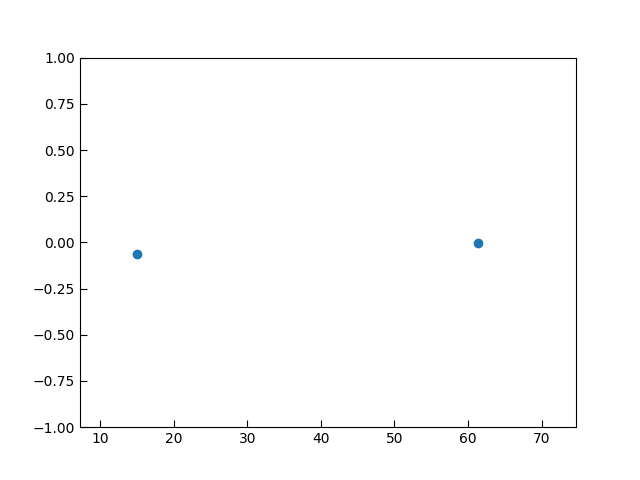

In [40]:
%matplotlib widget
fig,ax = plt.subplots()
ax.scatter(fits_arm1.arm_length, fits_arm1.gamma)
ax.set_ylim(-1,1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-bc0a71f77a6b>", line 2, in <module>
    ax.plot(arm1.x_tracing, arm1.y_tracing)
NameError: name 'arm1' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/daniel

NameError: name 'arm1' is not defined

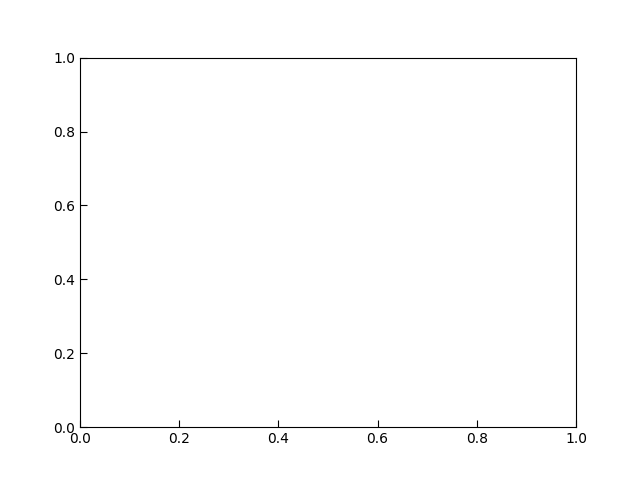

In [41]:
fig, ax = plt.subplots()
ax.plot(arm1.x_tracing, arm1.y_tracing)
ax.plot(arm2.x_tracing, arm2.y_tracing)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

In [ ]:
#df_fits.head
#print(df_fits["amplitude"], df_fits["center"], df_fits["sigma"],  df_fits["gamma"], df_fits["x_tracing"], df_fits["y_tracing"], df_fits["x_max"], df_fits["y_max"], df_fits["w1"], df_fits["w2"], df_fits["arm"], df_fits["fractured"])
#print(df_fits["w1"], df_fits["w2"])
#df_fits.to_csv('Arm_width_rho.csv')

In [ ]:
df_print = pd.DataFrame(zip(df_fits.amplitude, df_fits.center, df_fits.sigma, df_fits.gamma, df_fits.x_tracing, df_fits.y_tracing, df_fits.x_max, df_fits.y_max, df_fits.w1, df_fits.w2, df_fits.arm, df_fits.fractured, df_fits.id_tracing))


In [ ]:
df_print.to_csv('Arm2_widths_rho_adicionales_Ago4.csv')

In [ ]:
def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Verificar que x_eval y y_eval no estén vacíos
    if len(x_eval) == 0 or len(y_eval) == 0:
        print(f"Advertencia: 'x_eval' o 'y_eval' están vacíos para params id: {params.get('id_tracing', 'desconocido')}")
        return {'x_max': np.nan, 'y_max': np.nan, 'w1': np.nan, 'w2': np.nan}

    # Continúa si no están vacíos
    x_max, y_max = find_maximum(x_eval, y_eval)

    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []
    if isinstance(intersection, MultiPoint):
        points_intercept = list(intersection)
    elif not intersection.is_empty:
        points_intercept = [intersection]

    points_intercept = [[point.x, point.y] for point in points_intercept]

    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}



df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)